In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split 

In [2]:
# import and process data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import seaborn as sns
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# organise the data

# convert from pandas df to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to numbers
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species == 'setosa'] = 0 not required as already zeroes are there
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [32]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.8)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)
def getBatches(batchSize):

    # test_data.tensors[0].shape[0]
    # batch_size = 16
    train_loader = DataLoader(train_data, batch_size=int(batchSize), shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
    return train_loader, test_loader

In [17]:
def createModel():
    return nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )


In [53]:
def createANewModel():
    ANN = createModel()
    lossFunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANN.parameters(), lr=0.001)
    return ANN, lossFunction, optimizer

In [33]:
# train the model

epochs = 1000

def trainModel(ANN, lossFunction, optimizer, train_loader, test_loader):
    trainAcc = [] # this'd contain accuracies after all batches complete, basically 1 epoch
    testAcc = []  # this'd also contain accuracies after each epoch but on test data, (the last epoch accuracy ~= final accuracy??)
    losses = []   # to store mean batch losses, similar to trainAcc

    for _ in range(epochs):
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            
            yHat = ANN(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append((torch.mean((torch.argmax(yHat, axis=1) == y).float()) * 100).item())
            batchLoss.append(loss.item())

        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        test_x, test_y = next(iter(test_loader))
        with torch.no_grad(): # grad calculations not required during testing, this will decrease computation time
            predLabels = ANN.forward(test_x)
        testAcc.append((torch.mean((torch.argmax(predLabels, axis=1) == test_y).float()) * 100).item())

    return trainAcc, losses, testAcc


In [9]:
# create a 1D smoothing filter
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

### Actual experiment

In [54]:
batches = np.power(2, np.arange(1,7))

allTrainAcc = np.zeros((len(batches), epochs))
allTestAcc = np.zeros((len(batches), epochs))
for i in range(len(batches)):
    ANN, lossFunction, optimizer = createANewModel()
    train_loader, test_loader = getBatches(batches[i])
    trainAcc, losses, testAcc = trainModel(ANN, lossFunction, optimizer, train_loader, test_loader)
    # allTrainAcc[i,:] = trainAcc
    # allTestAcc[i,:] = testAcc
    allTrainAcc[i,:] = smooth(trainAcc, 10)
    allTestAcc[i,:] = smooth(testAcc, 10)



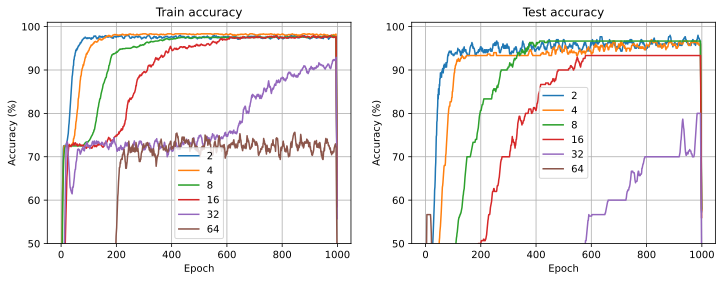

In [56]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(allTrainAcc.T)
ax[0].set_title('Train accuracy')
ax[1].plot(allTestAcc.T)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in batches]

for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()
plt.show()